In [1]:
from lsdt_dynasim import*

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
from scipy.interpolate import interp1d
  
#########################################################################
##### Beschreibung Programm #############################################
#########################################################################

""" 
Das Programm dient der Berechnung des Systemverhaltens von Schwingungsfähigen Systemen

Bemerkungen:
- Die numerische Berechnung erfolgt mittels Runge Kutta Verfahren (RK4)
- Die Genauigkeit der Ergebnisse hängen von der Zeitschrittweite und der Simulationsdauer ab
- Eine zu kein gewählte Schrittweite führt in der Regel zu einer Energiezufuhr ins System
- Je höher die Steifigkeit des Systems, desto kleiner muss die Simulationsschrittweite gewählt werden
"""
#########################################################################
##### Allgemeine Einstellungen ##########################################
#########################################################################

Bilder_speichern                     = True
CSV_speichern                        = False
CSV_speichern_Blender                = False

#########################################################################
##### Messung einlesen (optional) #######################################
#########################################################################

#########################################################################
##### Simulationsparameter ##############################################
#########################################################################

Input_t_start                        = 0             # Simulationszeit Star
Input_t_ende                         = 3             # Simulationszeit Ende
Input_delta_t                        = 0.00001       # Zeitschrittweite

# Initial and end values
Input_gx                             = 0             # Gravitationsbeschleunigung x-Richtung, Standard: 0
Input_gy                             = 0             # Gravitationsbeschleunigung y-Richtung, Standard: 0
Input_gz                             = 0             # Gravitationsbeschleunigung z-Richtung, Standard: -9.81

# Initial and end values
Input_E1_Masse_Feder_c                     = 1000          # Federsteifigkeit
Input_E1_Masse_Feder_Fv                    = 100           # Federvorspannkraft (zur Kompensation von Gewichtskräften, Positiv: Kraft zieht Feder zusammen, Negativ: Kraft drückt Feder auseinander)
Input_E2_Masse_Rolle_m                     = 10            # Masse der Rolle
Input_E2_Masse_Rolle_R                     = 1             # Radius der Rolle
Input_E2_Masse_Rolle_aj                    = 0.2           # Abstand Kraftangriffspunkt Knoten i vom Drehpunkt
Input_E2_Masse_Rolle_ak                    = 0.5           # Abstand Kraftangriffspunkt Knoten j vom Drehpunkt
Input_E3_Masse_Daempfer_d                  = 5.0           # Dämpfungskonstante

#########################################################################
##### Anfangsrandbedingungen der Elemente ###############################
#########################################################################

K1_Masse.x   = 0.0
K2_Masse.x   = 0.0
K3_Masse.x   = 0.0
K4_Masse.x   = 0.0
K5_Masse.x   = 0.0

#########################################################################
##### Erstellung aller Elemente #########################################
#########################################################################
"""
Modell:
    E1_Masse:   Feder
    E2_Masse:   Rolle  
    E3_Masse:   Dämpfer
"""

E1_Masse                               = class_Feder_x_Masse(Input_E1_Masse_Feder_c, Input_E1_Masse_Feder_Fv, [K1_Masse, K2_Masse])
E2_Masse                               = class_DGL_Rolle_rot_y_Masse(Input_E2_Masse_Rolle_m, Input_E2_Masse_Rolle_R, Input_E2_Masse_Rolle_aj, Input_E2_Masse_Rolle_ak, [K5_Masse, K2_Masse, K4_Masse])
E3_Masse                               = class_Daempfer_x_Masse(Input_E3_Masse_Daempfer_d, [K2_Masse, K3_Masse])

#########################################################################
##### Start der Simulation ##############################################
#########################################################################

t = Input_t_start
while (t < Input_t_ende):
    # Erst einmal alle Knotenkräfte zu Null setzen, da diese an den Knoten aufsummiert werden
    Reset_Knotenkraefte_Masse()            
                                
    #Berechnung der Kräfte an den Federn und Dämpfern
    #    für alle Elemente
    E1_Masse.Berechnung_Kraefte()
    E2_Masse.Berechnung_Kraefte()        
    E3_Masse.Berechnung_Kraefte()    
    
    #Berechung der massebehafteten Elemente  
    #    nur für Elemente mit Masse
    E2_Masse.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)              
    
    # Berechnung Energien    
    #    für alle Elemente
    E1_Masse.Berechnung_Energien(Input_delta_t)    
    E2_Masse.Berechnung_Energien(Input_delta_t)        
    E3_Masse.Berechnung_Energien(Input_delta_t)            
    
    # Datenlogger Knoten
    Datenlogger_Knoten_schreiben_Masse(t)
    
    #Datenlogger Elemente
    #    für alle Elemente
    datenlogger_E1_Masse.Werte_anhaengen(E1_Masse)
    datenlogger_E2_Masse.Werte_anhaengen(E2_Masse)    
    datenlogger_E3_Masse.Werte_anhaengen(E3_Masse)        
                          
    t = t + Input_delta_t

if (CSV_speichern == True):
    csv_schreiben_Masse('../output_csv/lsdt_dynasim_boxautomat.csv',datenlogger_K2_Masse)
    
if (CSV_speichern_Blender == True):
    csv_schreiben_Masse('../output_csv_blender/lsdt_dynasim_boxautomat.csv',datenlogger_K2_Masse)

In [2]:
eigenkreisfrequenz_berechnen(datenlogger_t_Masse,datenlogger_K5_Masse.roty)

Periodendauer: 0.74
Frequenz: 1.35
Eigenkreisfrequenz: 8.485


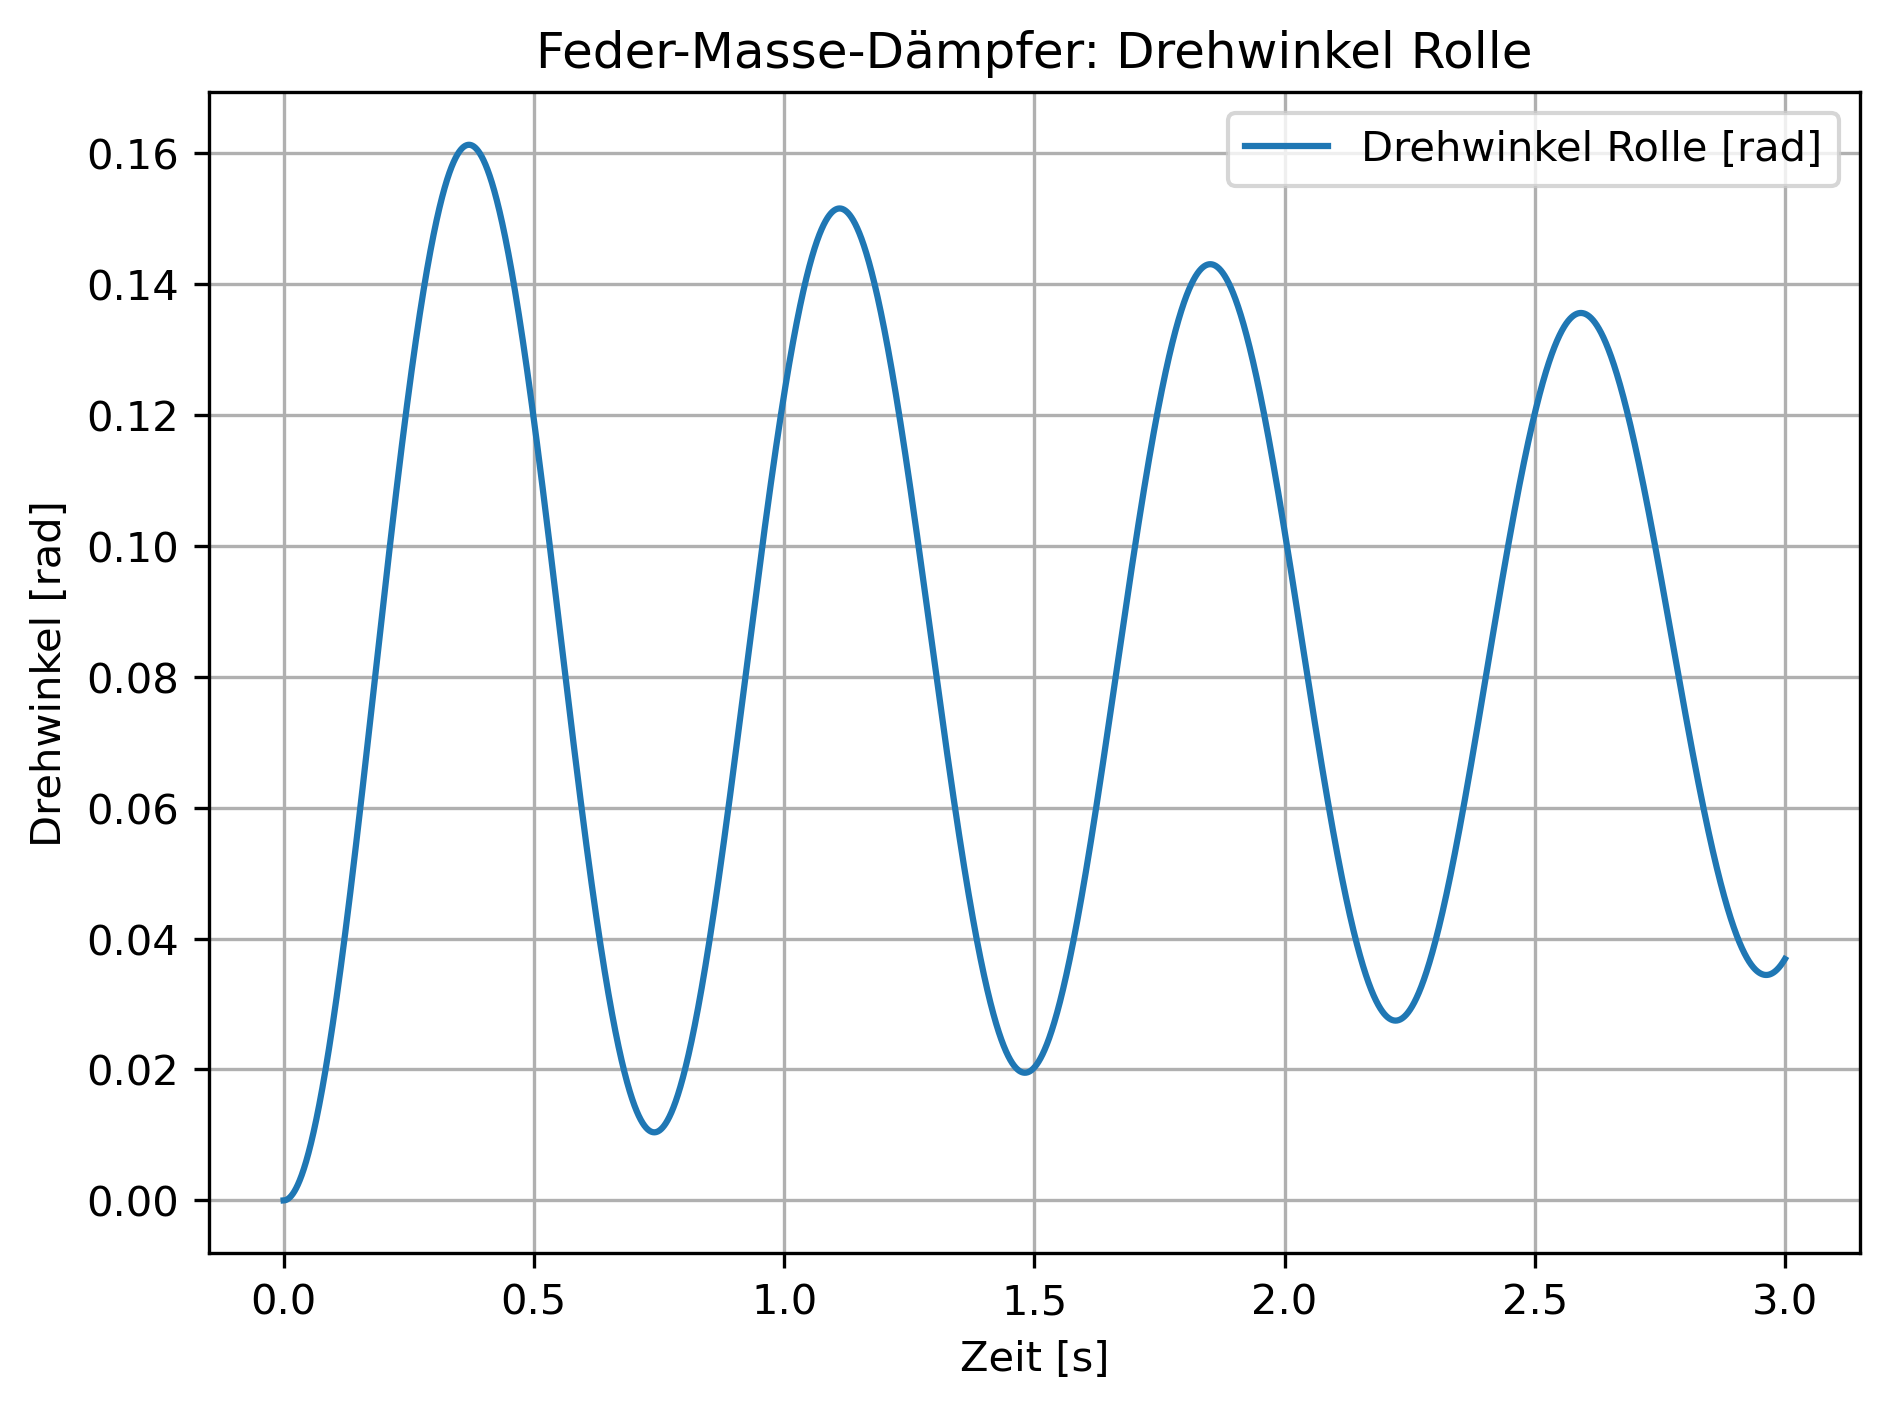

In [3]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Dämpfer: Drehwinkel Rolle')
plt.plot(datenlogger_t_Masse,datenlogger_K5_Masse.roty,label='Drehwinkel Rolle [rad]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.ylabel('Drehwinkel [rad]')
plt.grid(True)
plt.tight_layout()
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_boxautomat1.png')

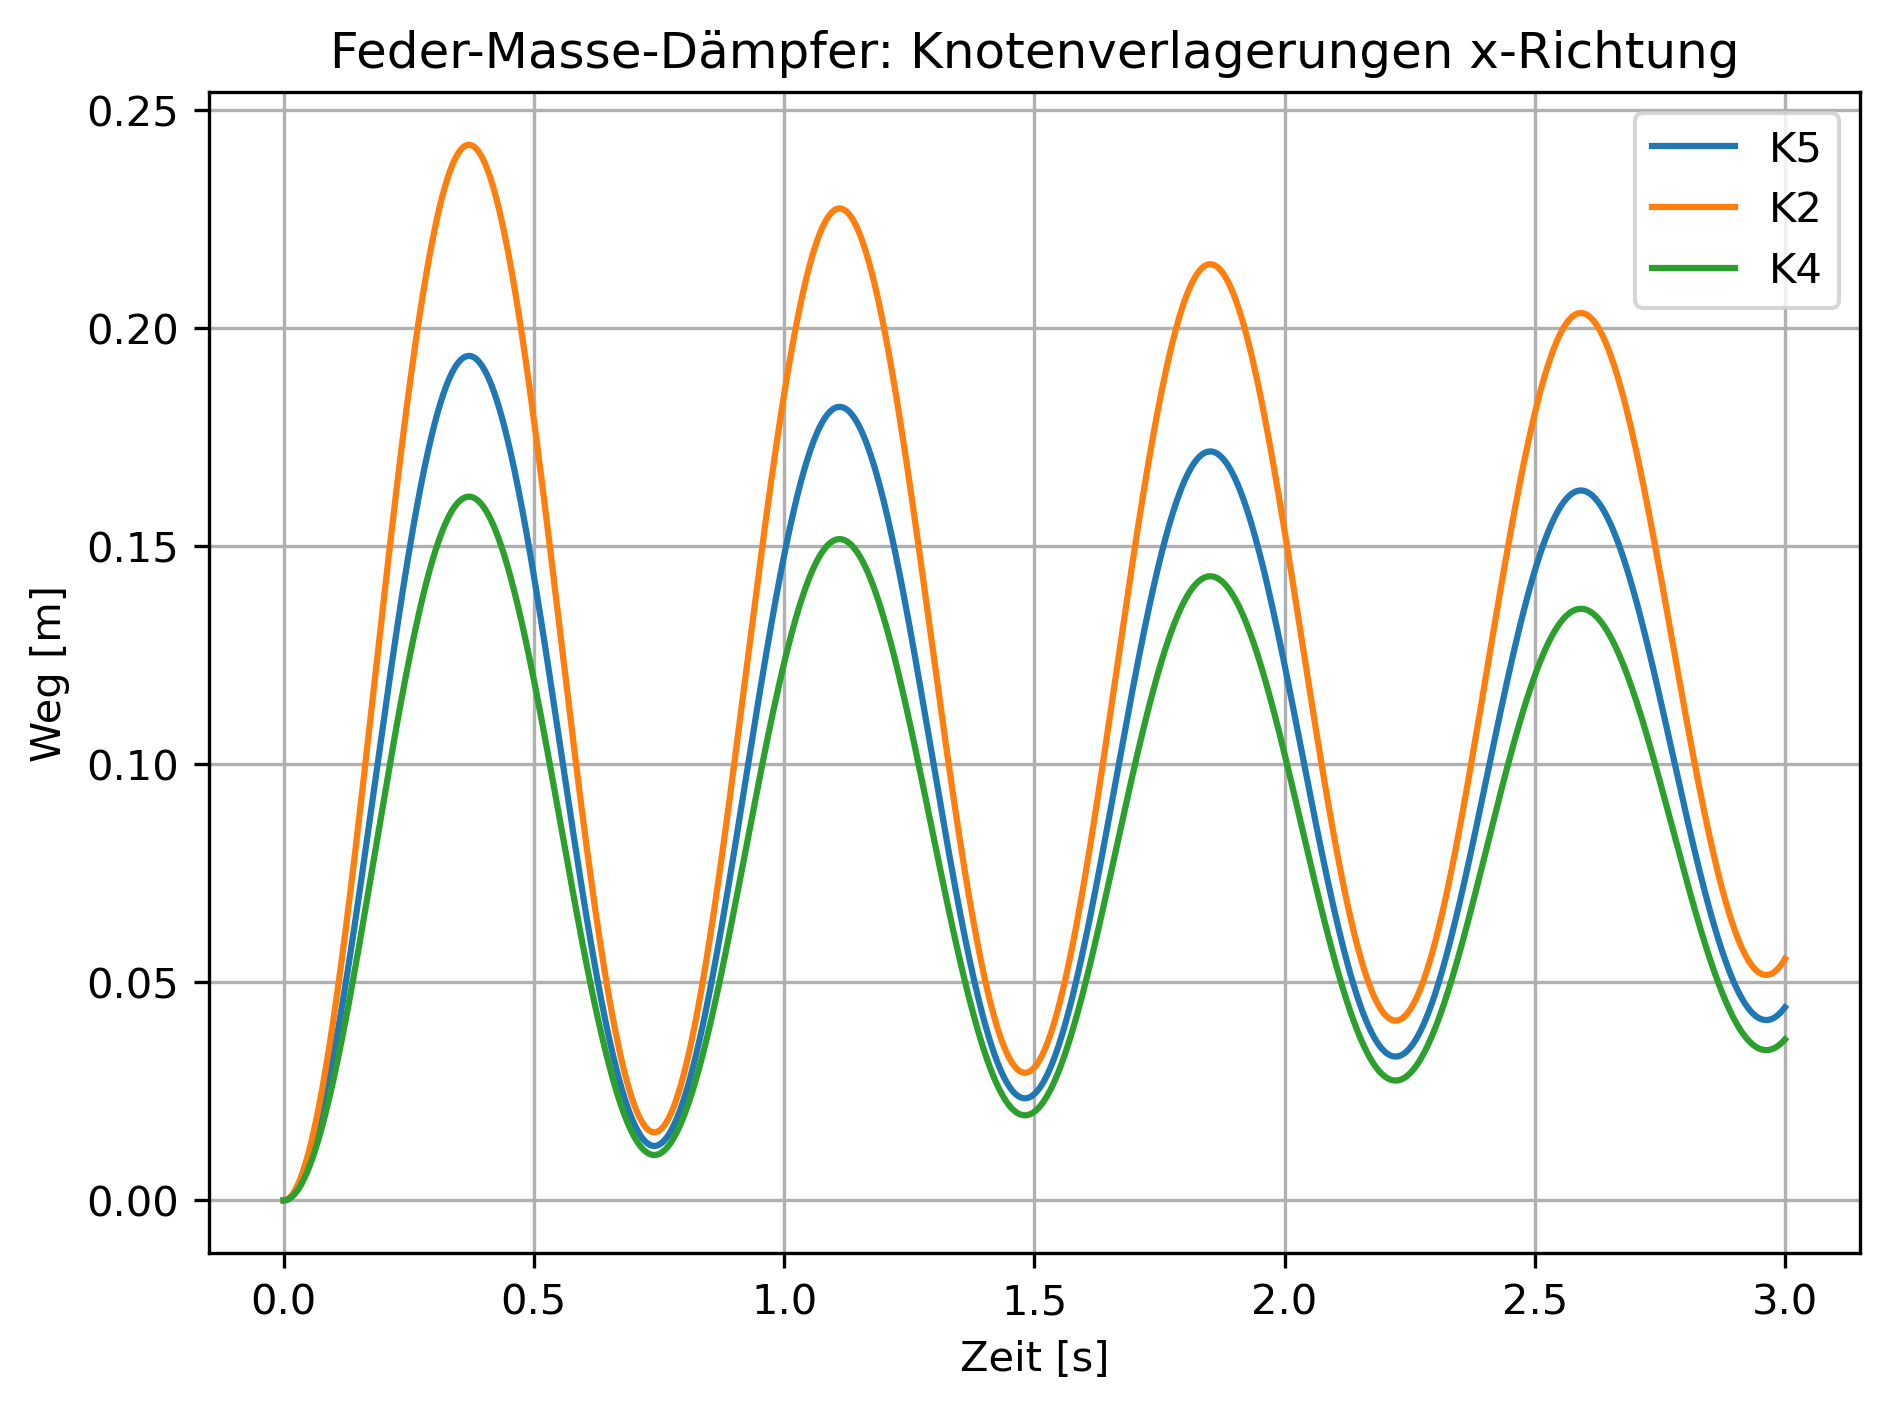

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Dämpfer: Knotenverlagerungen x-Richtung')
plt.plot(datenlogger_t_Masse,datenlogger_K2_Masse.x,label='K5')
plt.plot(datenlogger_t_Masse,datenlogger_K4_Masse.x,label='K2')
plt.plot(datenlogger_t_Masse,datenlogger_K5_Masse.x,label='K4')
#plt.xlim(0,20)
plt.ylabel('Weg [m]')
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.tight_layout()
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_boxautomat2.png')

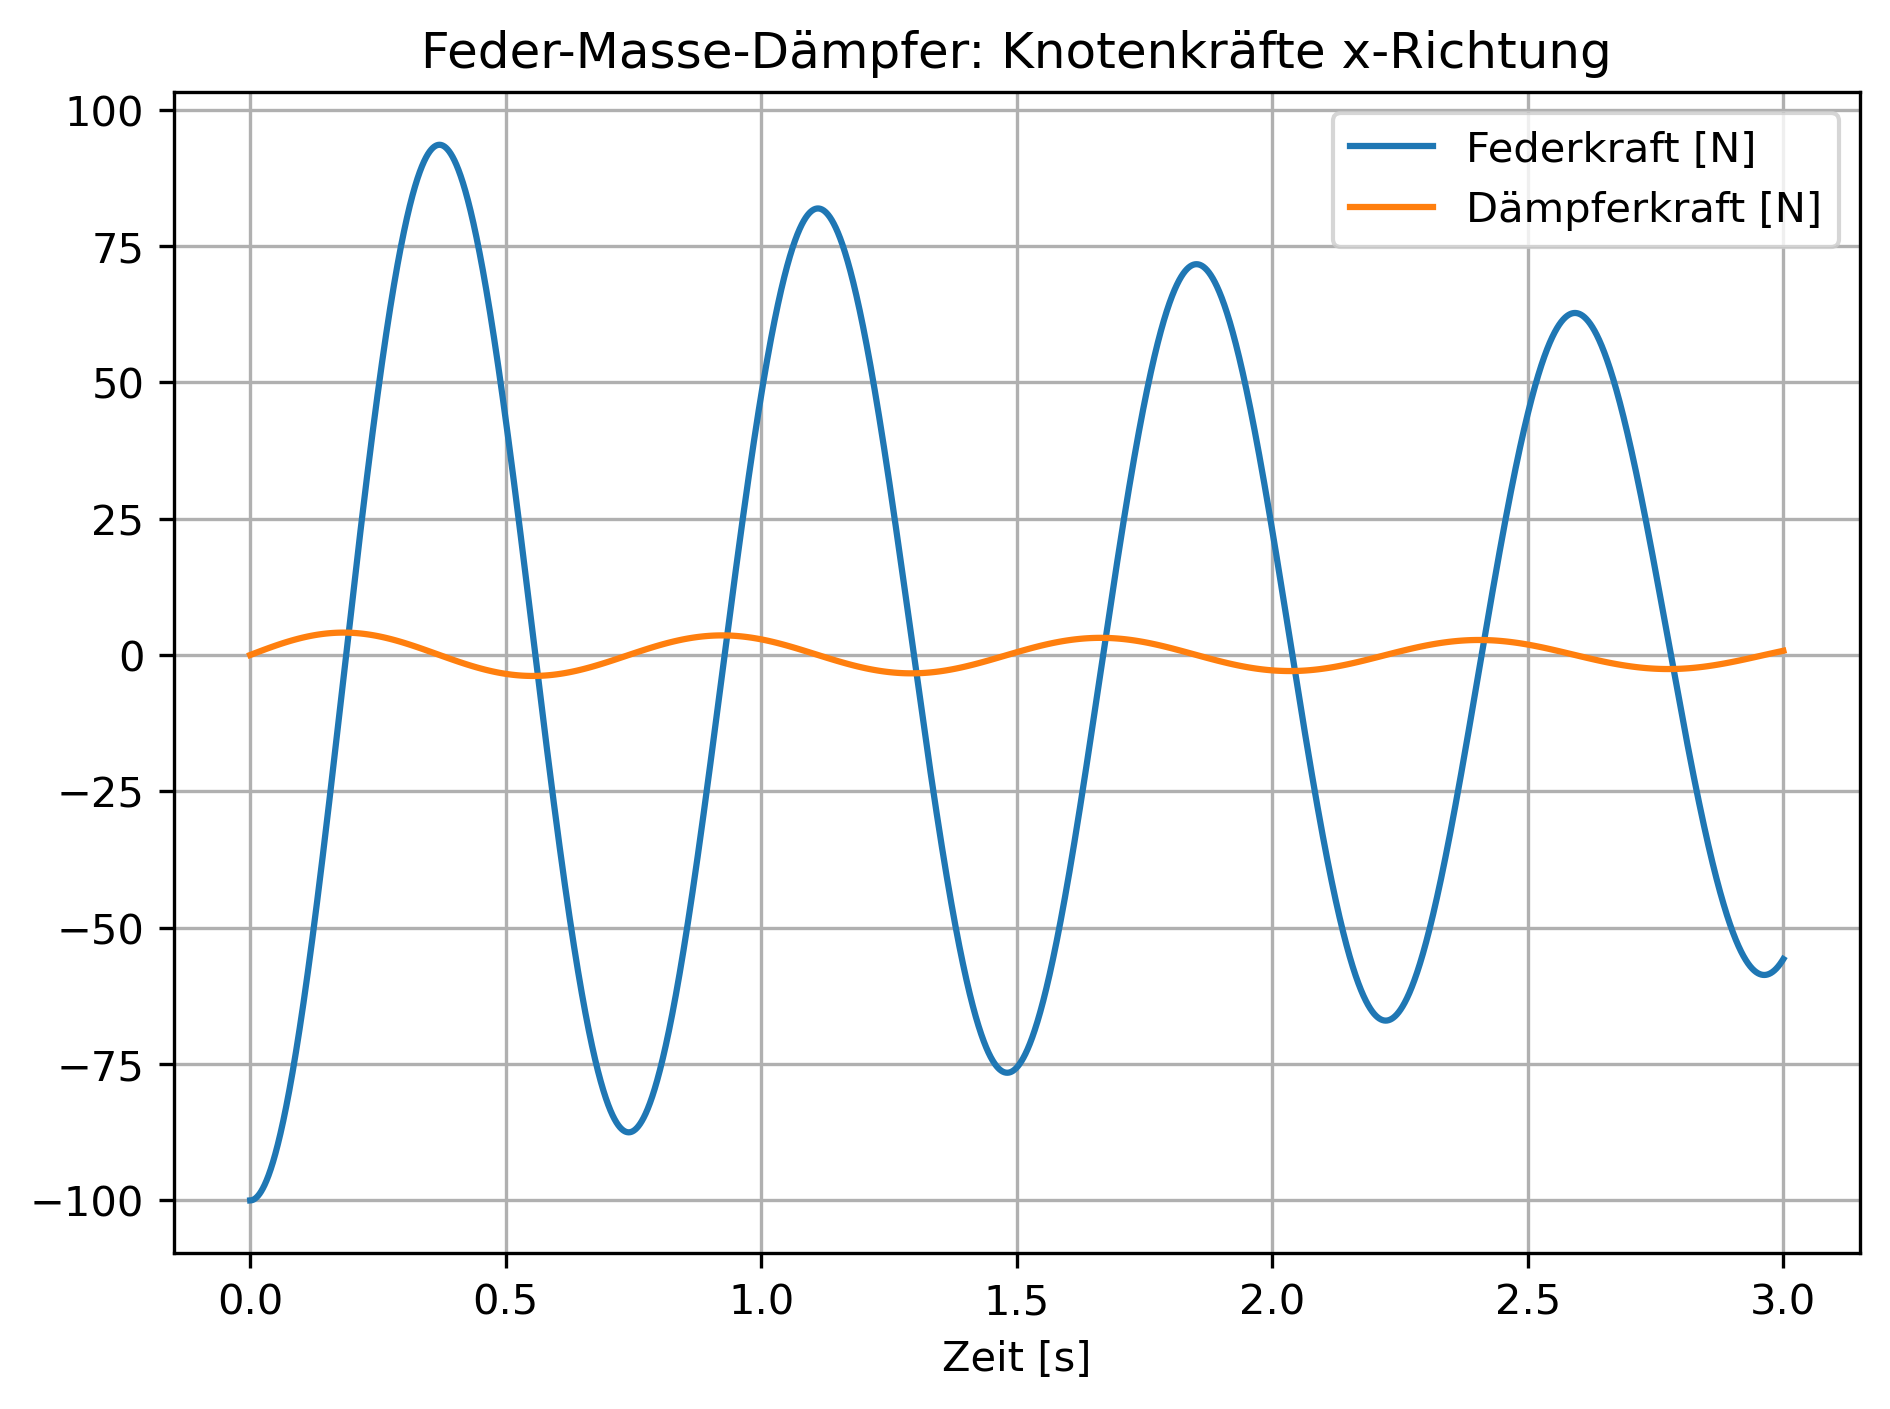

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Dämpfer: Knotenkräfte x-Richtung')
plt.plot(datenlogger_t_Masse,datenlogger_K1_Masse.F_x,label='Federkraft [N]')
plt.plot(datenlogger_t_Masse,datenlogger_K3_Masse.F_x,label='Dämpferkraft [N]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.tight_layout()
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_boxautomat3.png')

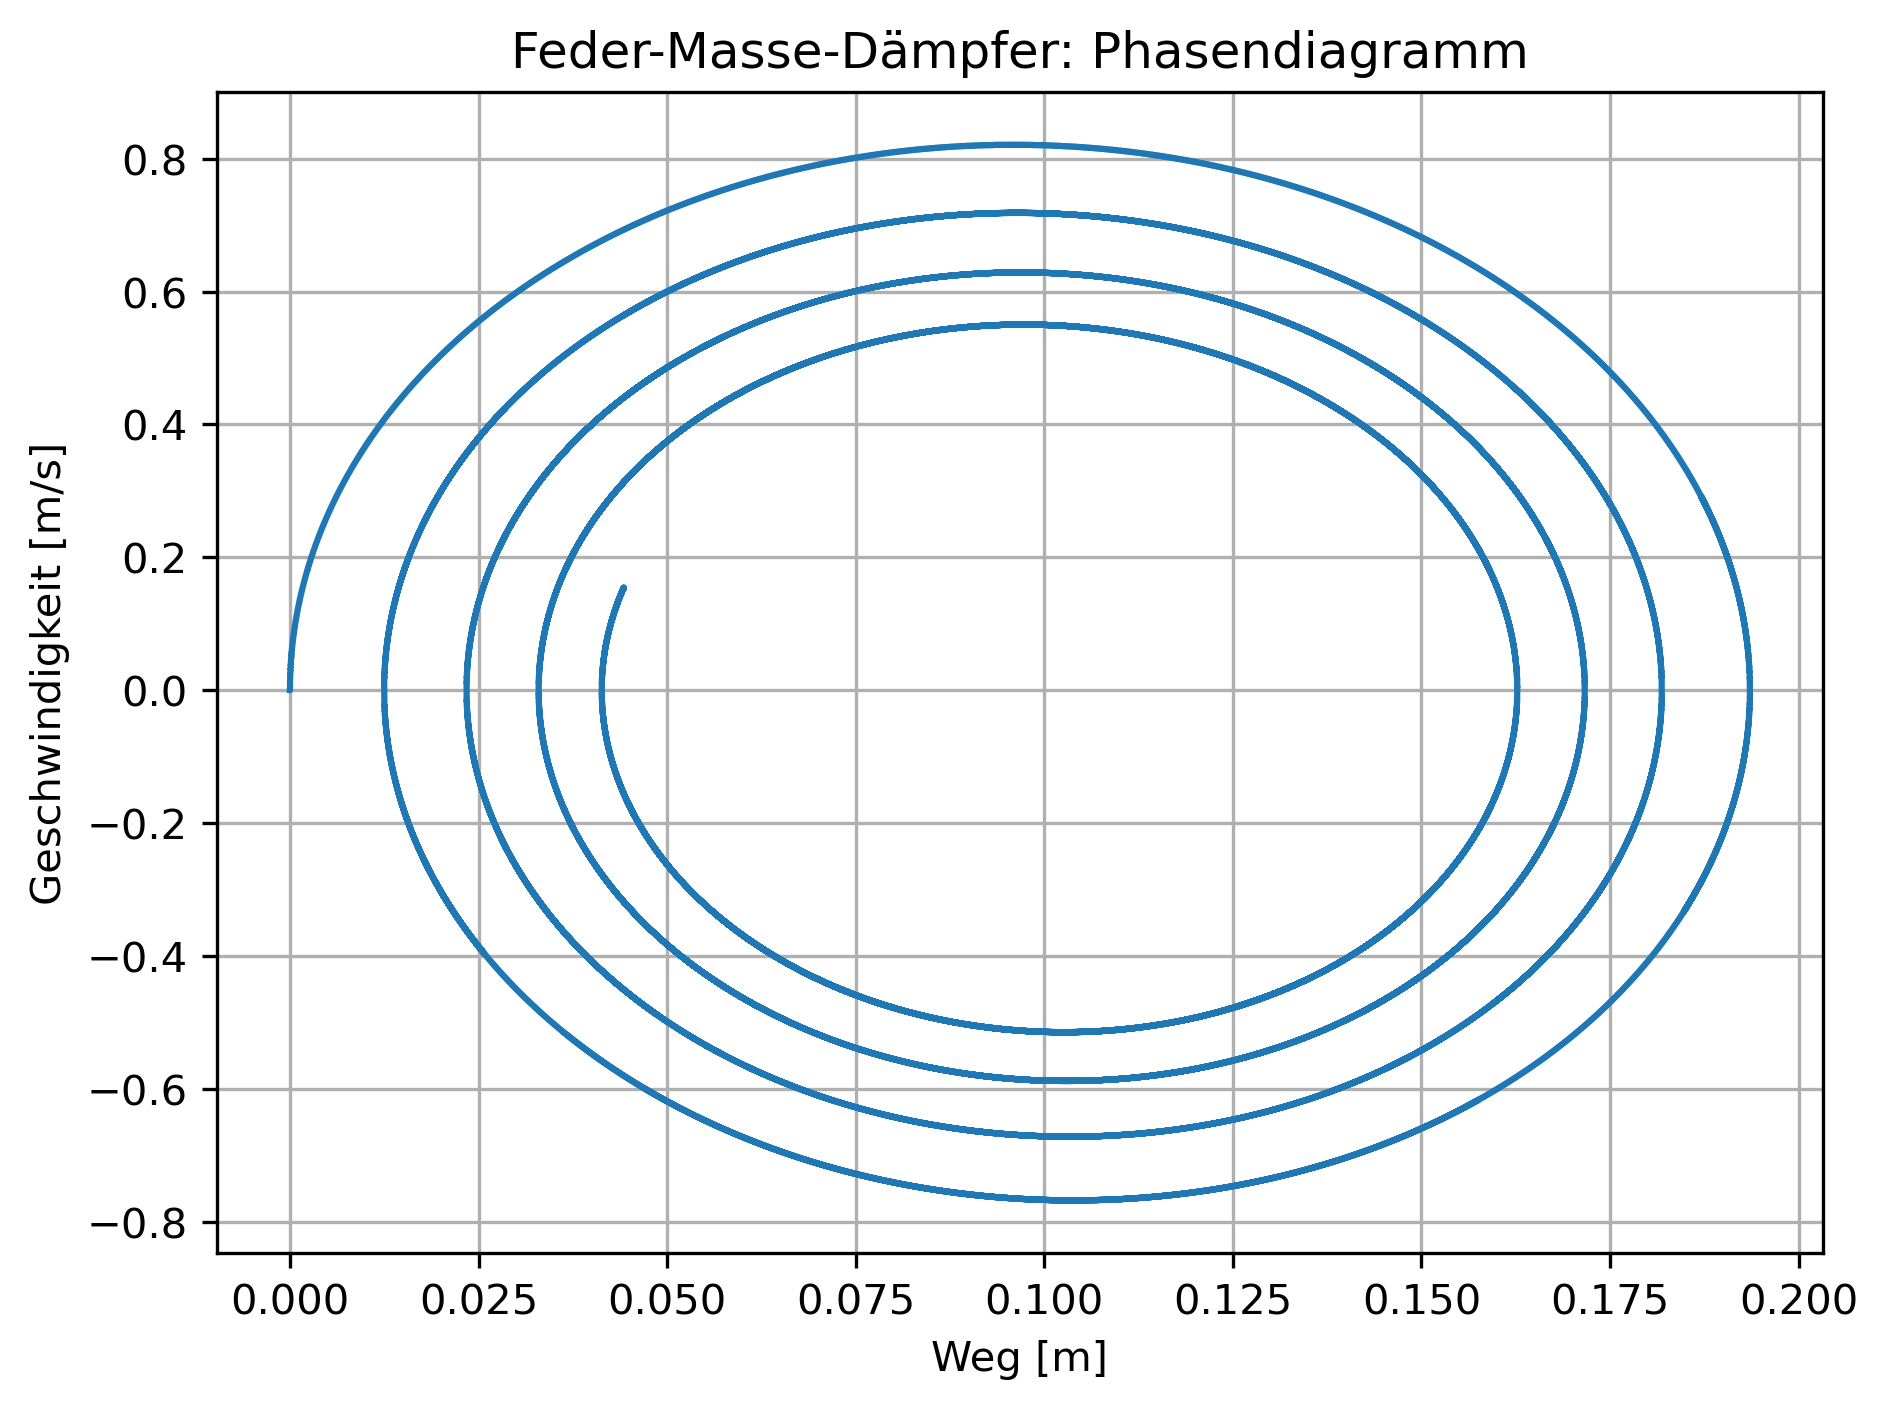

In [6]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Dämpfer: Phasendiagramm')
plt.plot(datenlogger_K2_Masse.x,datenlogger_K2_Masse.x_p,label='Rolle')
#plt.xlim(0,20)
plt.xlabel('Weg [m]')
plt.ylabel('Geschwindigkeit [m/s]')
plt.tight_layout()
plt.grid(True)
#plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_boxautomat4.png')

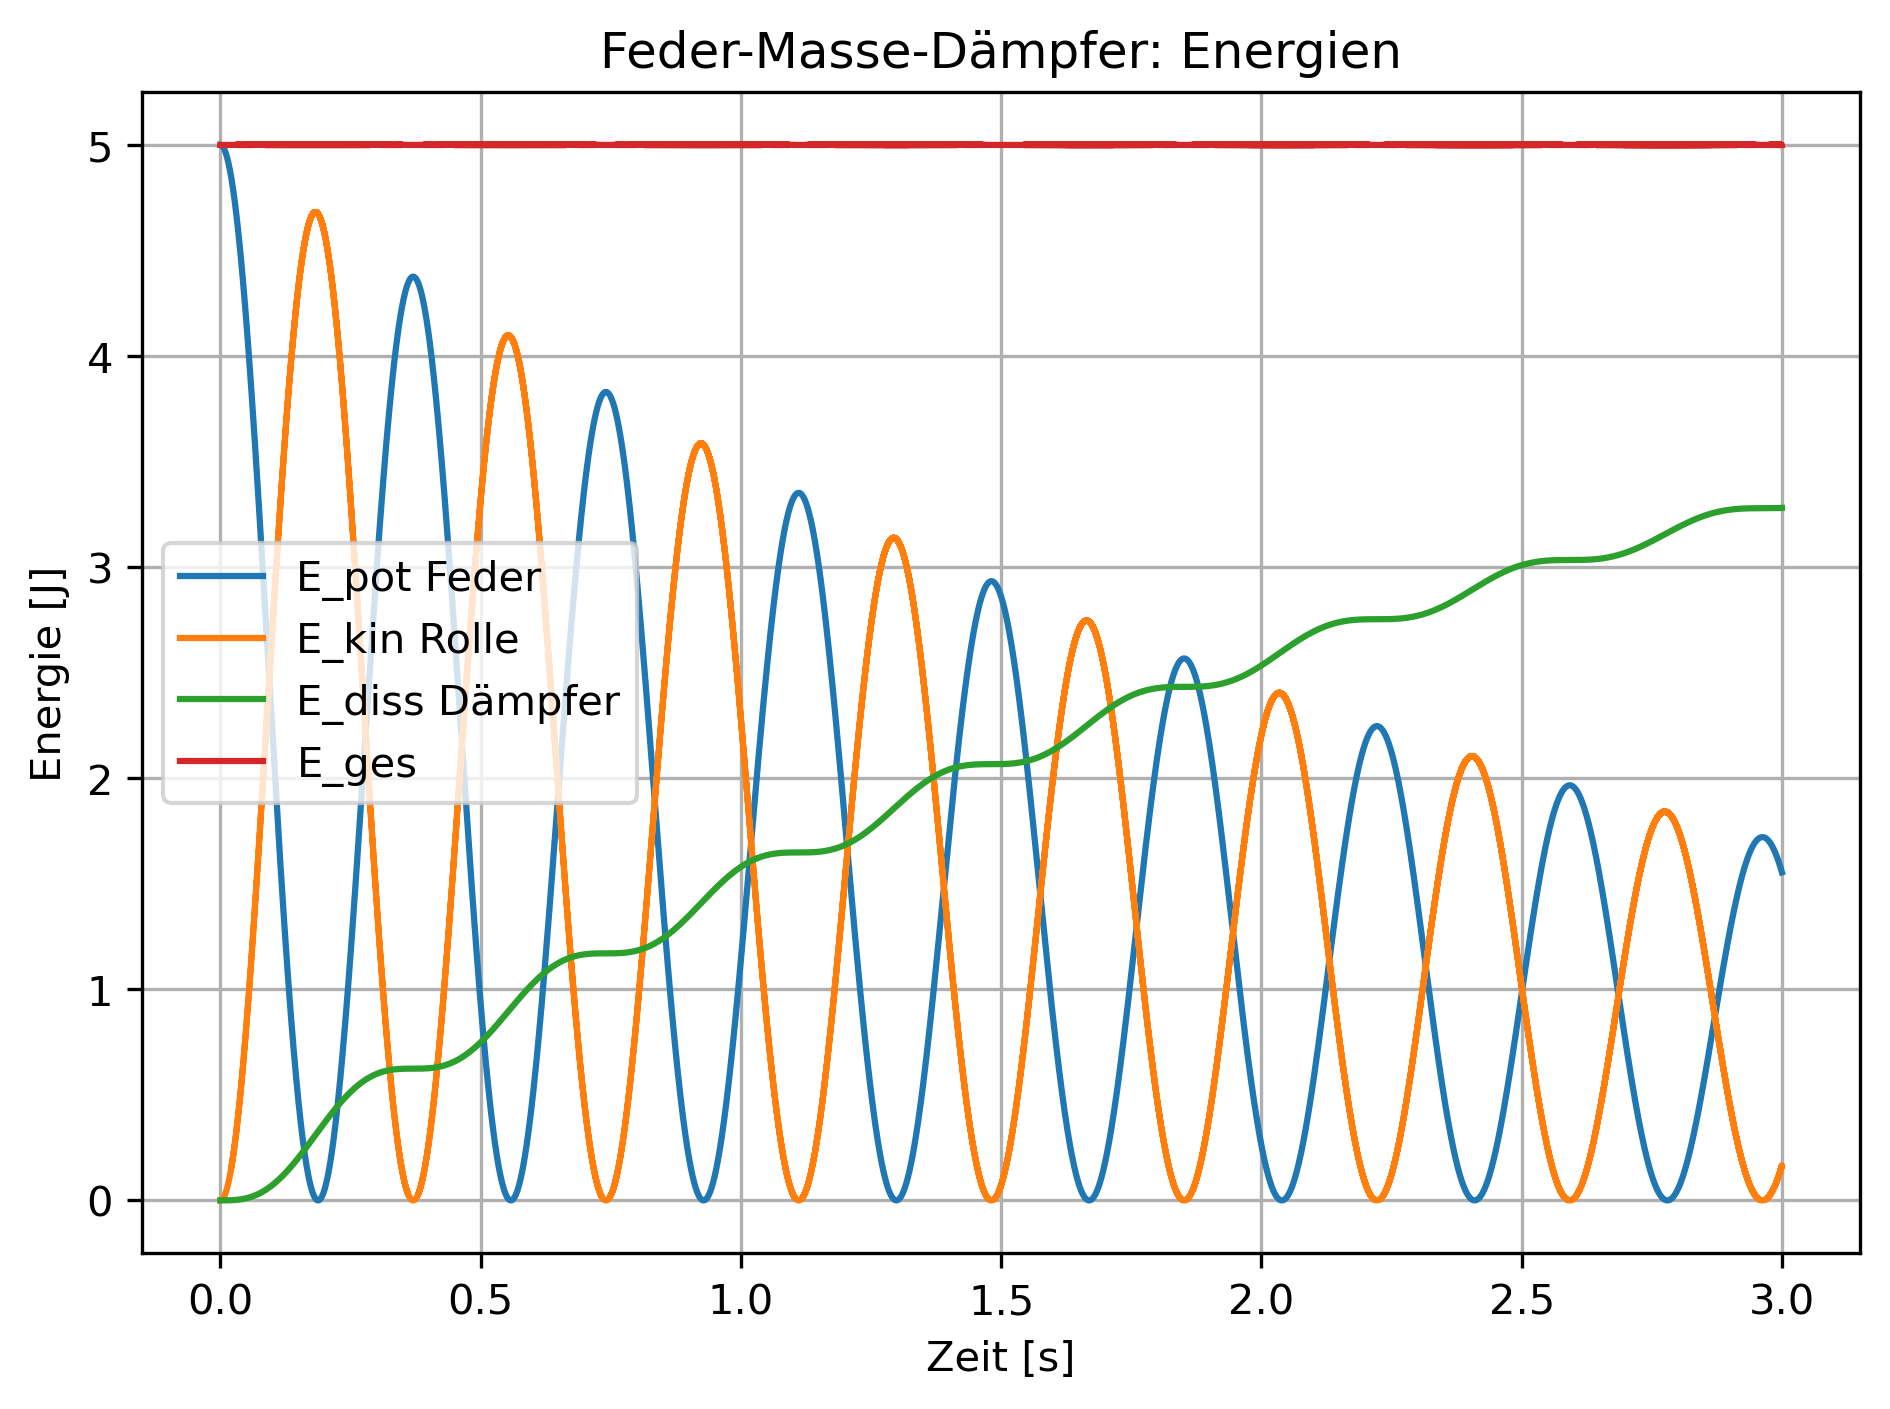

In [7]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Dämpfer: Energien')
E_ges = []
for point in range(len(datenlogger_E2_Masse.E_pot)):
    E_ges.append(datenlogger_E1_Masse.E_pot[point] + datenlogger_E2_Masse.E_pot[point] + datenlogger_E2_Masse.E_kin[point] + datenlogger_E3_Masse.E_diss[point])
plt.plot(datenlogger_t_Masse,datenlogger_E1_Masse.E_pot,label='E_pot Feder')
plt.plot(datenlogger_t_Masse,datenlogger_E2_Masse.E_kin,label='E_kin Rolle')
plt.plot(datenlogger_t_Masse,datenlogger_E3_Masse.E_diss,label='E_diss Dämpfer')
plt.plot(datenlogger_t_Masse,E_ges,label='E_ges')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.ylabel('Energie [J]')
plt.tight_layout()
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_boxautomat5.png')